
# Local


In [1]:
! pip install --quiet -r ../requirements.txt

import sys
import os
sys.path.append(os.path.expanduser("~/repos/NeurOps/pytorch"))


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip


# Colab


In [2]:
# ! git clone https://github.com/SuReLI/NeurOps.git
# ! git clone https://github.com/k8lion/GrowAndPrune.git
# %cd GrowAndPrune/src
# ! pip install --quiet -r ../requirements.txt

# import sys
# import os
# sys.path.append("../../NeurOps/pytorch")

# Imports

In [3]:
import numpy as np
import torch
import copy
import math
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML


from neurops import *

from growprune import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/kaitlin/repos/GrowAndPrune/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kaitlin/repos/GrowAndPrune/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
#data = TransferToyData(line=False)
data = EffDimToyData()
train_loader, val_loader, test_loader = split_dataset(data, val_size=0.1, test_size=0.1, batch_size=32)

In [7]:
#model = ModMLP(2,2,1,50).to(device)
model = ModMLP(64,32,1,3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.BCEWithLogitsLoss()

In [8]:
for _ in range(10):
    _,_,_ = train(model, train_loader, optimizer, criterion, epochs=10, val_loader=val_loader, device=device, verbose=False, val_verbose=False, val_acts=True)
    test(model, val_loader, criterion, device=device, verbose=True)

Average loss: 0.0106, Accuracy: 91/100 (91.00%)
Average loss: 0.0067, Accuracy: 92/100 (92.00%)
Average loss: 0.0050, Accuracy: 94/100 (94.00%)
Average loss: 0.0040, Accuracy: 95/100 (95.00%)
Average loss: 0.0035, Accuracy: 97/100 (97.00%)
Average loss: 0.0032, Accuracy: 96/100 (96.00%)
Average loss: 0.0030, Accuracy: 96/100 (96.00%)
Average loss: 0.0029, Accuracy: 96/100 (96.00%)
Average loss: 0.0028, Accuracy: 96/100 (96.00%)
Average loss: 0.0028, Accuracy: 96/100 (96.00%)


In [23]:
acts = defaultdict(list)
test(model, val_loader, criterion, device=device, verbose=False)
for key, value in model.activations.items():
    acts[key] = value.cpu()
    print("{:.3g}".format(orthogonality_gap(acts[key]).item()), end="\t")
_,_ = test(model, test_loader, criterion, device=device, verbose=True)
for effdim in [1,2,4,8,16,32,64]:
    print("EffDim: {}".format(effdim))
    newdata = EffDimToyData(effdim=effdim)
    modelcopy = copy.deepcopy(model)
    newtrain_loader, newval_loader, newtest_loader = split_dataset(newdata, val_size=0.1, test_size=0.1, batch_size=32)
    _,_ = test(model, newval_loader, criterion, device=device, verbose=False)
    for key, value in model.activations.items():
        acts[key] = value.cpu()
        print("{:.3g}".format(orthogonality_gap(acts[key]).item()), end="\t")
    _,_ = test(model, newtest_loader, criterion, device=device, verbose=True)
    opt = torch.optim.Adam(modelcopy.parameters(), lr=3e-5)
    for _ in range(10):
        _,_,_ = train(modelcopy, newtrain_loader, opt, criterion, epochs=10, val_loader=newval_loader, device=device, verbose=False, val_verbose=False, val_acts=True)
        test(modelcopy, newval_loader, criterion, device=device, verbose=False)
    for key, value in modelcopy.activations.items():
        acts[key] = value.cpu()
        print("{:.3g}".format(orthogonality_gap(acts[key]).item()), end="\t")
    _,_ = test(modelcopy, newtest_loader, criterion, device=device, verbose=True)

0.248	0.474	0.816	Average loss: 0.0042, Accuracy: 95/100 (95.00%)
EffDim: 1
0.259	0.741	0.816	Average loss: 0.0966, Accuracy: 4/100 (4.00%)
0.997	0.698	0.816	Average loss: 0.0045, Accuracy: 99/100 (99.00%)
EffDim: 2
0.575	0.625	0.816	Average loss: 0.0343, Accuracy: 74/100 (74.00%)
0.705	0.659	0.816	Average loss: 0.0020, Accuracy: 100/100 (100.00%)
EffDim: 4
0.421	0.506	0.816	Average loss: 0.0498, Accuracy: 70/100 (70.00%)
0.514	0.557	0.816	Average loss: 0.0030, Accuracy: 100/100 (100.00%)
EffDim: 8
0.316	0.589	0.816	Average loss: 0.1169, Accuracy: 58/100 (58.00%)
0.387	0.47	0.816	Average loss: 0.0099, Accuracy: 91/100 (91.00%)
EffDim: 16
0.248	0.519	0.816	Average loss: 0.1511, Accuracy: 61/100 (61.00%)
0.296	0.436	0.816	Average loss: 0.0172, Accuracy: 79/100 (79.00%)
EffDim: 32
0.22	0.448	0.816	Average loss: 0.0344, Accuracy: 77/100 (77.00%)
0.269	0.442	0.816	Average loss: 0.0087, Accuracy: 92/100 (92.00%)
EffDim: 64
0.242	0.524	0.816	Average loss: 0.0394, Accuracy: 60/100 (60.00%)
0.1

Average loss: 2.1189, Accuracy: 55/100 (55.00%)
Angle: 0	0.716	0.7	0.99	Average loss: 0.0005, Accuracy: 100/100 (100.00%)
Angle: 10	0.722	0.783	0.99	Average loss: 0.0750, Accuracy: 85/100 (85.00%)
Angle: 20	0.745	0.896	0.99	Average loss: 0.1762, Accuracy: 73/100 (73.00%)
Angle: 30	0.787	0.981	0.99	Average loss: 0.1683, Accuracy: 72/100 (72.00%)
Angle: 40	0.801	0.977	0.99	Average loss: 0.2500, Accuracy: 64/100 (64.00%)
Angle: 50	0.869	0.99	0.99	Average loss: 0.3766, Accuracy: 51/100 (51.00%)
Angle: 60	0.918	0.994	0.99	Average loss: 0.4497, Accuracy: 59/100 (59.00%)
Angle: 70	0.941	0.994	0.99	Average loss: 0.8468, Accuracy: 47/100 (47.00%)
Angle: 80	0.935	0.995	0.99	Average loss: 0.9106, Accuracy: 54/100 (54.00%)
Angle: 90	0.957	0.995	0.99	Average loss: 0.8875, Accuracy: 54/100 (54.00%)
Angle: 100	0.957	0.995	0.99	Average loss: 1.2647, Accuracy: 47/100 (47.00%)
Angle: 110	0.966	0.995	0.99	Average loss: 1.1335, Accuracy: 54/100 (54.00%)
Angle: 120	0.967	0.995	0.99	Average loss: 1.2523, Ac

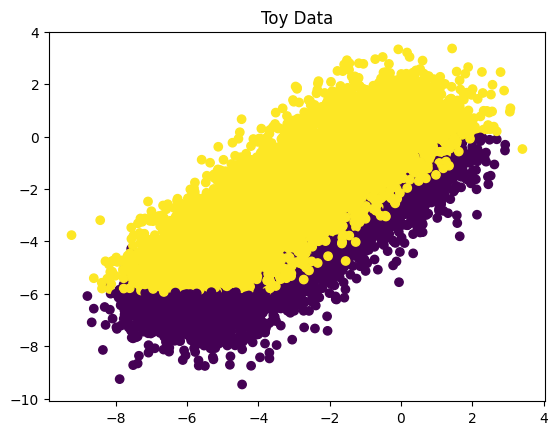

In [11]:
test(model, val_loader, criterion, device=device, verbose=True)
fig, ax = plt.subplots()
ax.scatter(data.X[:,0], data.X[:,1], c=data.y)
ax.set_title("Toy Data")
for angle in range(0, 180, 10):
    print("Angle:", angle, end="\t")
    newdata = TransferToyData(angle=0, x=-2*math.radians(angle), y = -2*math.radians(angle), line=False)
    ax.scatter(newdata.X[:,0], newdata.X[:,1], c=newdata.y)
    acts = defaultdict(list)
    train_loader, val_loader, test_loader = split_dataset(newdata, val_size=0.1, test_size=0.1, batch_size=32)
    test(model, val_loader, criterion, device=device, verbose=False)
    for key, value in model.activations.items():
        acts[key] = value.cpu()
        print("{:.3g}".format(orthogonality_gap(acts[key]).item()), end="\t")
    test(model, test_loader, criterion, device=device, verbose=True)

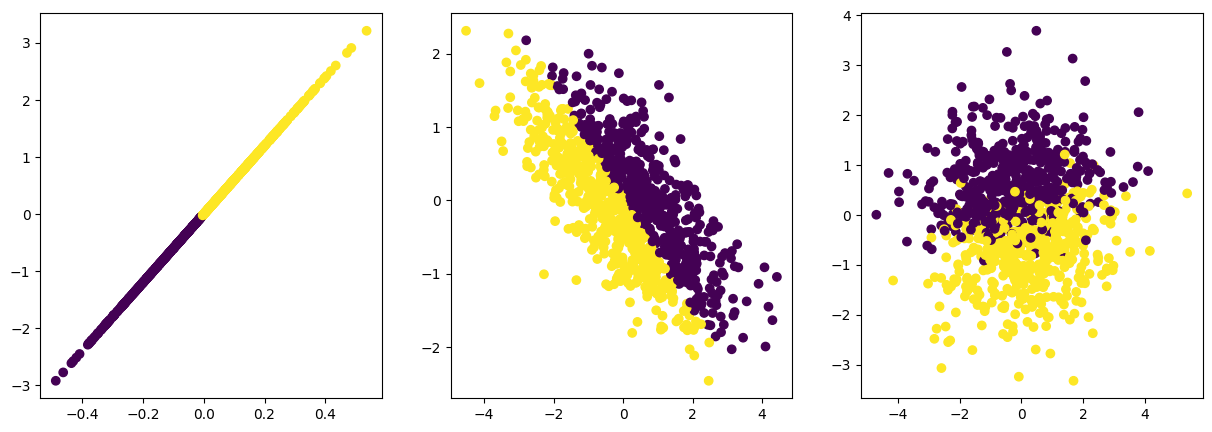

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
for index, effdim in enumerate([1,2,3]):
    dat = EffDimToyData(effdim=effdim)
    ax[index].scatter(dat.X[:,0]+dat.X[:,1], dat.X[:,2], c=dat.y)

